In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Examples of usage

In [4]:
from oja_code.oja_utils  import positive_semidefined, get_stream, max_eigenvec
from oja_code.oja import Oja
from oja_code.optimizer import SGD, SGD_with_decreasing_step, AcSGD, AcSGD_with_decreasing_step

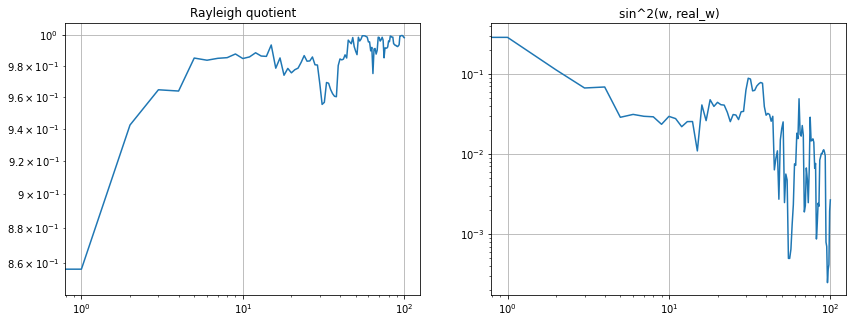

In [5]:
# Usage example
d = 3
l = 1

# creating positive semidefined matrix
A = positive_semidefined(d)

# generator for A_n (to get next iteration run "next(a_stream)")
a_stream = get_stream(A)

optimizer = AcSGD(alpha=0.1, beta=0.1) # create optimizer with desired parameters
oja = Oja(d, optimizer) # set dimension for the weights and optimizer to use
oja.run(a_stream, max_iter=100) # run max_iter steps of Oja's algorithm
oja.pretty_plot(A,plt.loglog) # plot to see how good it did (you need to provide true value of A)

### Time for testing

In [6]:
MAX_ITER = 10**3

def make_test_case(d):
    A = positive_semidefined(d)

    a_stream = get_stream(A)
    
    return {
        'd': d,
        'A': A, 
        'A_stream': a_stream
    }

In [7]:
# define parameters for which we will conduct experiments 
# d - matrix dimension, l - lenths of the interval for uniform distribtion
ds = [10, 50]

test_cases = [make_test_case(d) for d in ds]

In [8]:
def run_test_case(test_case, initial_weight, optimizer_class, optim_params, plot=True):
    optimizer = optimizer_class(**optim_params)
    oja = Oja(test_case['d'], optimizer, initial_weight)
    oja.run(test_case['A_stream'], max_iter=MAX_ITER)
    if plot:
        oja.pretty_plot(test_case['A'])
    return oja

### Constant learning rate

In [9]:
sgd_params = [{'lr': 1e-1}, {'lr': 1e-2}, {'lr': 1e-3}]

sgd_results = []
for optim_params in sgd_params:
    for test_case in test_cases:
        sgd_results.append((run_test_case(test_case, None, SGD, optim_params, plot=False), test_case['A']))

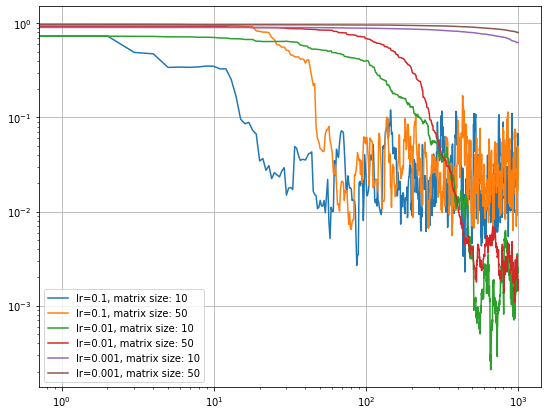

In [10]:
plt.figure(figsize=(9, 7))
for res in sgd_results:
    real_w = max_eigenvec(res[1])    
    loss = res[0].loss_history(real_w)
    label = res[0].optimizer.info().split()[-1] + f', matrix size: {res[1].shape[0]}'
    plt.loglog(loss, label=label)
    #plt.ylim((-1e-4, 0.001)) 
plt.grid()
plt.legend()

### Learning rate of n-th iteration = const / (beta + n)

In [11]:
lrs = [1e-1, 1]
betas = [1, 10, 100]
sgd_with_step_decrease_params = []
sgd_with_step_decrease = []

for lr in lrs:
    for beta in betas:
        sgd_with_step_decrease_params.append({'lr': lr, 'beta':beta})
        
for test_case in test_cases:
    for sgd_with_step_decrease_param in sgd_with_step_decrease_params:
        sgd_with_step_decrease.append(
            (run_test_case(test_case, 
                           None, 
                           SGD_with_decreasing_step, 
                           sgd_with_step_decrease_param, 
                           plot=False
                          ), 
             test_case['A']
            ))

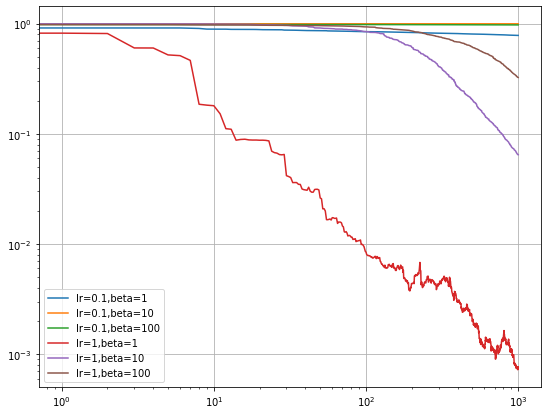

In [12]:
plt.figure(figsize=(9, 7))
for res in sgd_with_step_decrease:
    real_w = max_eigenvec(res[1])    
    loss = res[0].loss_history(real_w)
    if res[1].shape[0] == 50:
        label = res[0].optimizer.info().split()[-2] + res[0].optimizer.info().split()[-1]
        plt.loglog(loss, label=label)
    
plt.grid()
plt.legend()

### AcSGD

Note that it works and converges fast

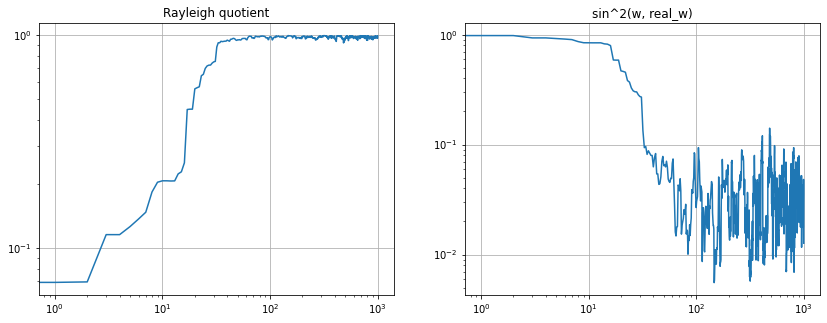

In [13]:
alpha,beta = .1,.1

optimizer = AcSGD(alpha,beta)
oja = Oja(test_cases[1]['d'], optimizer)
oja.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)
oja.pretty_plot(test_cases[1]['A'])

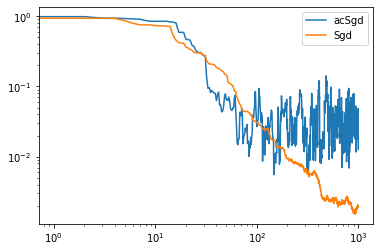

In [14]:
lr = .1
sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_cases[1]['d'], sgd)
oja_sgd.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_cases[1]['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()

## AcSGD with decreasing step

If decrease is $\frac{\alpha}{t}$, $\frac{\beta}{t}$ then it is the same as SGD with decreasing step

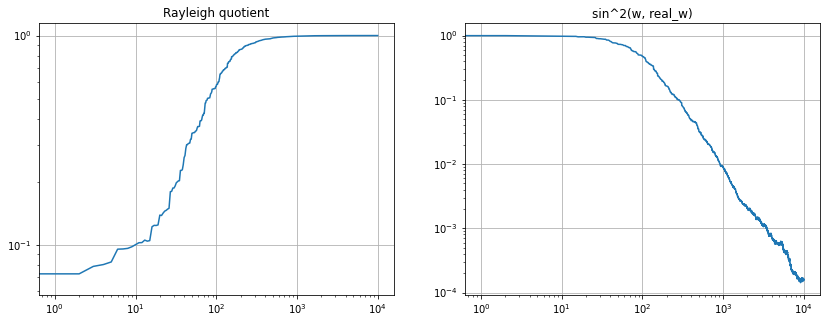

In [15]:
MAX_ITER = 10000

alpha,beta = 1,1

optimizer = AcSGD_with_decreasing_step(alpha,beta)
oja = Oja(test_cases[1]['d'], optimizer)
oja.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)
oja.pretty_plot(test_cases[1]['A'])

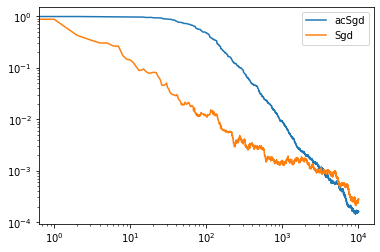

In [16]:
sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_cases[1]['d'], sgd)
oja_sgd.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_cases[1]['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


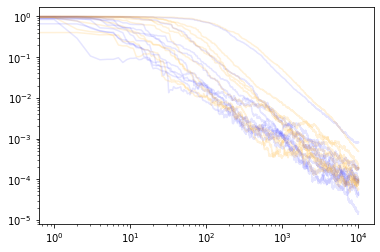

In [17]:
from tqdm import tqdm

loss_acSgd = []
loss_sgd = []
TRIALS = 10
for i in tqdm(range(TRIALS)):
    oja = run_test_case(test_cases[1], None, AcSGD_with_decreasing_step, {'alpha':alpha, 'beta':beta}, False)
    oja_sgd = run_test_case(test_cases[1], None, SGD_with_decreasing_step, {'lr': 1, 'beta':1}, False)
    
    real_w = max_eigenvec(test_cases[1]['A']) 

    loss_acSgd.append(oja.loss_history(real_w))
    loss_sgd.append(oja_sgd.loss_history(real_w))
    
for i in range(TRIALS):
    plt.loglog(loss_acSgd[i], color='blue', alpha=0.1)
    plt.loglog(loss_sgd[i], color='orange', alpha=0.15)

#### When $\gamma \neq 1$

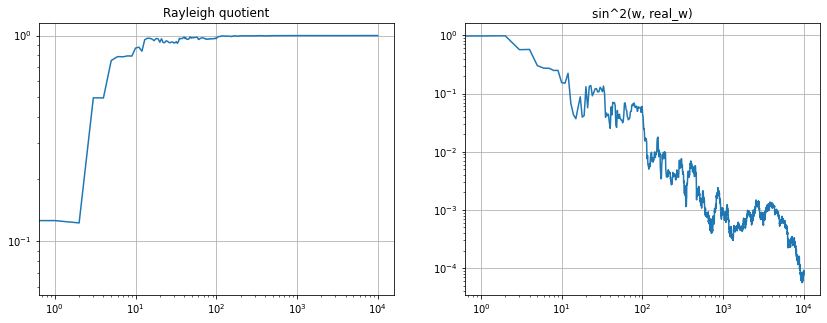

In [21]:
MAX_ITER = 10000

alpha,beta,gamma = 10,10,1.2

optimizer = AcSGD_with_decreasing_step(alpha, beta, gamma)
oja = Oja(test_cases[1]['d'], optimizer)
oja.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)
oja.pretty_plot(test_cases[1]['A'])

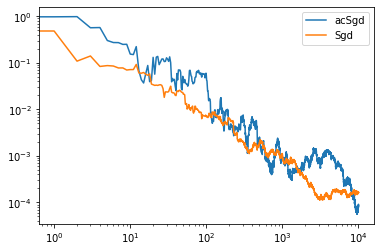

In [22]:
sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_cases[1]['d'], sgd)
oja_sgd.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_cases[1]['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()

100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


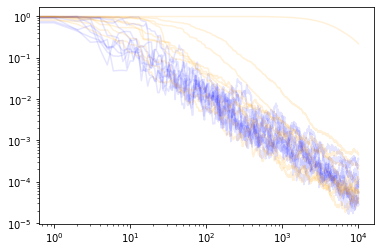

In [23]:
from tqdm import tqdm


loss_acSgd = []
loss_sgd = []
TRIALS = 10
for i in tqdm(range(TRIALS)):
    oja = run_test_case(test_cases[1], None, AcSGD_with_decreasing_step, {'alpha':alpha, 'beta':beta, 'gamma':gamma}, False)
    oja_sgd = run_test_case(test_cases[1], None, SGD_with_decreasing_step, {'lr': 1, 'beta':1}, False)
    
    real_w = max_eigenvec(test_cases[1]['A']) 

    loss_acSgd.append(oja.loss_history(real_w))
    loss_sgd.append(oja_sgd.loss_history(real_w))
    
for i in range(TRIALS):
    plt.loglog(loss_acSgd[i], color='blue', alpha=0.1)
    plt.loglog(loss_sgd[i], color='orange', alpha=0.15)